In [2]:
import warnings
from time import time
from tqdm import tqdm
import pickle
import os

import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import torch
from transformers import AutoModelForCausalLM, pipeline
from transformers import QuantizedCacheConfig, QuantoQuantizedCache, DynamicCache, QuantizedCache
from transformers.utils.logging import disable_progress_bar
import transformers

from kvpress import AdapPress, KnormPress

In [6]:
device = "cuda:0"
model = "HuggingFaceTB/SmolLM-135M"
compression_ratio = 0.5

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, prompt_text, continuation_text, device="cuda"):
    """
    Calculate perplexity on continuation_text after conditioning on prompt_text.
    """
    # Tokenize prompt (context we don't score)
    prompt_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)
    
    # Tokenize full text (prompt + continuation)
    full_text = prompt_text + continuation_text
    full_ids = tokenizer(full_text, return_tensors="pt").input_ids.to(device)
    
    # Create attention mask that only calculates loss on the continuation part
    # 1s for continuation tokens, 0s for prompt tokens
    continuation_length = full_ids.shape[1] - prompt_ids.shape[1]
    attention_mask = torch.zeros_like(full_ids)
    attention_mask[:, prompt_ids.shape[1]:] = 1
    
    # Calculate loss
    press = AdapPress(compression_ratio)
    with press(model):
        with torch.no_grad():
            outputs = model(full_ids, labels=full_ids)
            # Get loss for each token
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = full_ids[..., 1:].contiguous()
            
            # Use CrossEntropyLoss with reduction='none' to get per-token loss
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), 
                             shift_labels.view(-1))
            
            # Reshape loss to match token dimensions
            loss = loss.view(shift_labels.size())
            
            # Only consider loss for continuation tokens 
            # (subtract 1 to account for the shift in labels)
            continuation_loss = loss[:, prompt_ids.shape[1]-1:]
            
            # Average NLL loss for continuation tokens
            avg_nll = continuation_loss.mean().item()
            
            # Perplexity = exp(avg_nll)
            ppl = torch.exp(torch.tensor(avg_nll)).item()
        
    return ppl

def evaluate_on_pg19(model_name, context_lengths=[0, 1000, 2000, 4000, 8000, 16000, 32000], 
                     continuation_length=1000, num_samples=50):
    """
    Evaluate a model on PG19 with different context lengths.
    """
    # Load model and tokenizer
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Load PG19 test dataset
    dataset = load_dataset("pg19", split="test")
    
    # Limit to first num_samples if specified
    if num_samples:
        dataset = dataset.select(range(min(num_samples, len(dataset))))
    
    results = []
    
    # Process each document
    for doc_idx, document in tqdm(enumerate(dataset), total=len(dataset)):
        text = document["text"]
        doc_results = {"document_id": doc_idx}
        
        # Test different context lengths
        for context_length in context_lengths:
            # If context_length is 0, we're predicting from scratch
            if context_length == 0:
                prompt_text = ""
                continuation_text = text[:continuation_length]
            else:
                # Otherwise use context_length tokens as prompt and measure perplexity on the following continuation_length tokens
                prompt_text = text[:context_length]
                continuation_text = text[context_length:context_length+continuation_length]
            
            # Skip if not enough text
            if len(continuation_text) < continuation_length / 2:
                continue
                
            # Calculate perplexity
            try:
                ppl = calculate_perplexity(model, tokenizer, prompt_text, continuation_text, device)
                doc_results[f"ppl_ctx{context_length}"] = ppl
            except Exception as e:
                print(f"Error processing document {doc_idx} with context {context_length}: {e}")
                doc_results[f"ppl_ctx{context_length}"] = float('nan')
        
        results.append(doc_results)
    
    # Convert to DataFrame and aggregate results
    df = pd.DataFrame(results)
    
    # Compute summary statistics
    summary = {}
    for context_length in context_lengths:
        col = f"ppl_ctx{context_length}"
        if col in df.columns:
            summary[context_length] = {
                "mean_ppl": df[col].mean(),
                "median_ppl": df[col].median(),
                "std_ppl": df[col].std()
            }
    
    # Generate visualization
    plot_perplexity_vs_context(summary, context_lengths)
    
    return df, summary

def plot_perplexity_vs_context(summary, context_lengths):
    """
    Plot perplexity vs context length.
    """
    plt.figure(figsize=(10, 6))
    
    # Extract data
    valid_lengths = [l for l in context_lengths if l in summary]
    mean_ppls = [summary[l]["mean_ppl"] for l in valid_lengths]
    std_ppls = [summary[l]["std_ppl"] for l in valid_lengths]
    
    # Plot with error bars
    plt.errorbar(valid_lengths, mean_ppls, yerr=std_ppls, marker='o', linestyle='-')
    
    # Format plot
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Context Length (tokens)')
    plt.ylabel('Perplexity')
    plt.title('Perplexity vs Context Length on PG19')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    # Save and show plot
    plt.savefig("perplexity_vs_context.png")
    plt.show()

if __name__ == "__main__":
    # Replace with your model name
    model_name = "HuggingFaceTB/SmolLM-135M"
    
    # Define context lengths to evaluate
    context_lengths = [0, 128, 512, 1024, 2048, 4096, 8192, 16000, 32000]
    
    # Run evaluation
    results_df, summary = evaluate_on_pg19(
        model_name=model_name,
        context_lengths=context_lengths,
        continuation_length=1000,  # Length of continuation to measure perplexity on
        num_samples=25  # Number of PG19 test samples to evaluate
    )
    
    # Save results
    results_df.to_csv("pg19_perplexity_results.csv")
    
    # Print summary
    print("\nPerplexity Summary:")
    for ctx_len, stats in sorted(summary.items()):
        print(f"Context Length {ctx_len}: Mean PPL = {stats['mean_ppl']:.2f}, Median PPL = {stats['median_ppl']:.2f}")



Testing compression ratio: 0.5
Processing prompt 1/1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.32it/s]



Summary Statistics:
Compression ratio 0.5: Mean PPL = 19581.58, Median PPL = 33.46


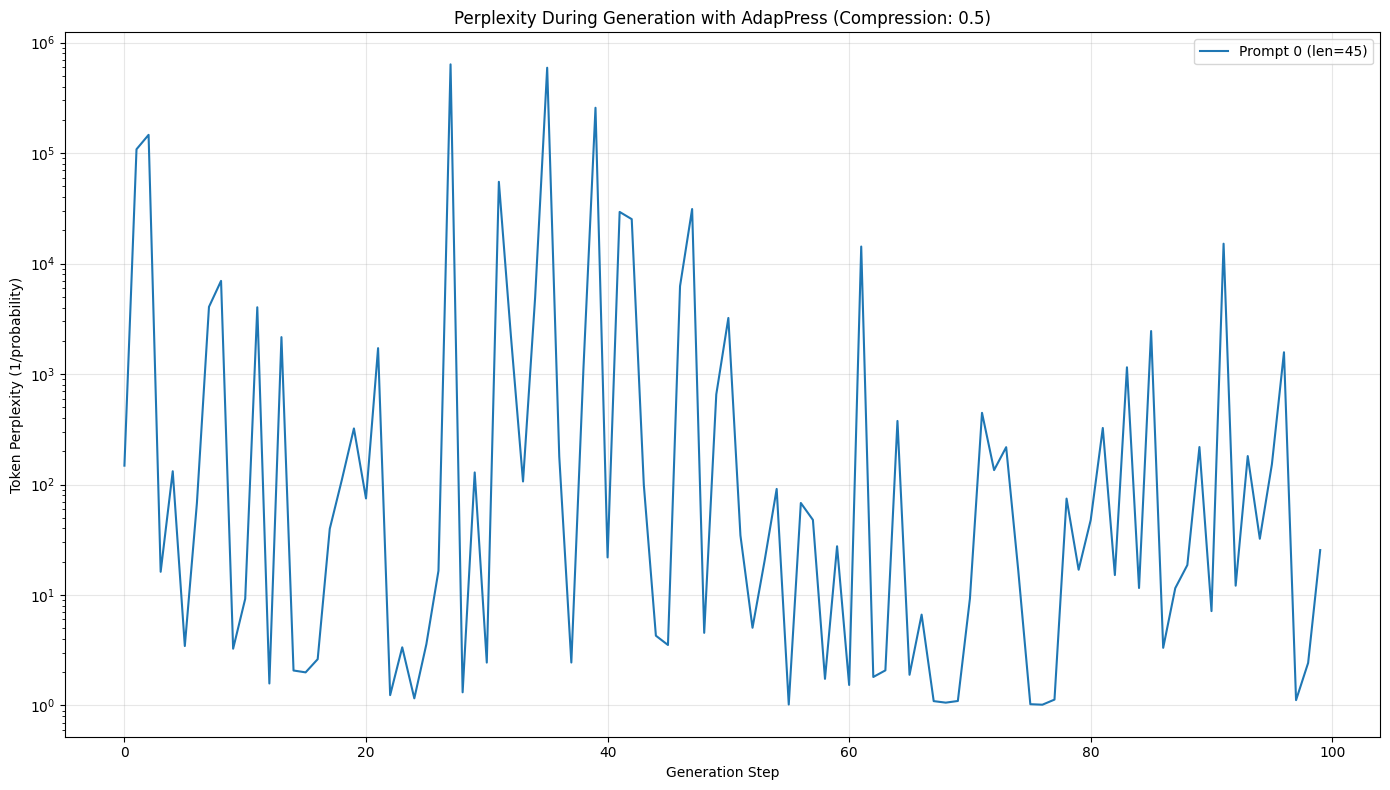

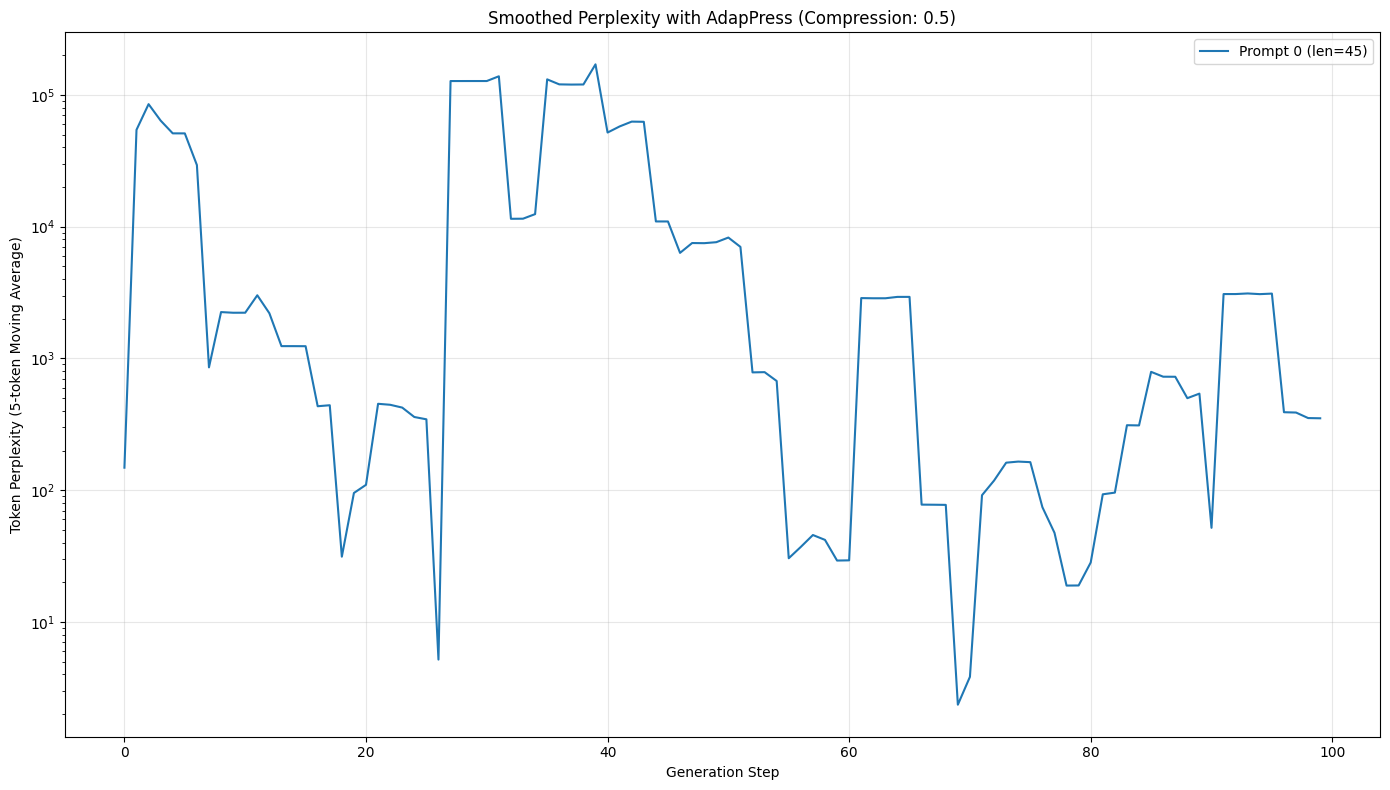

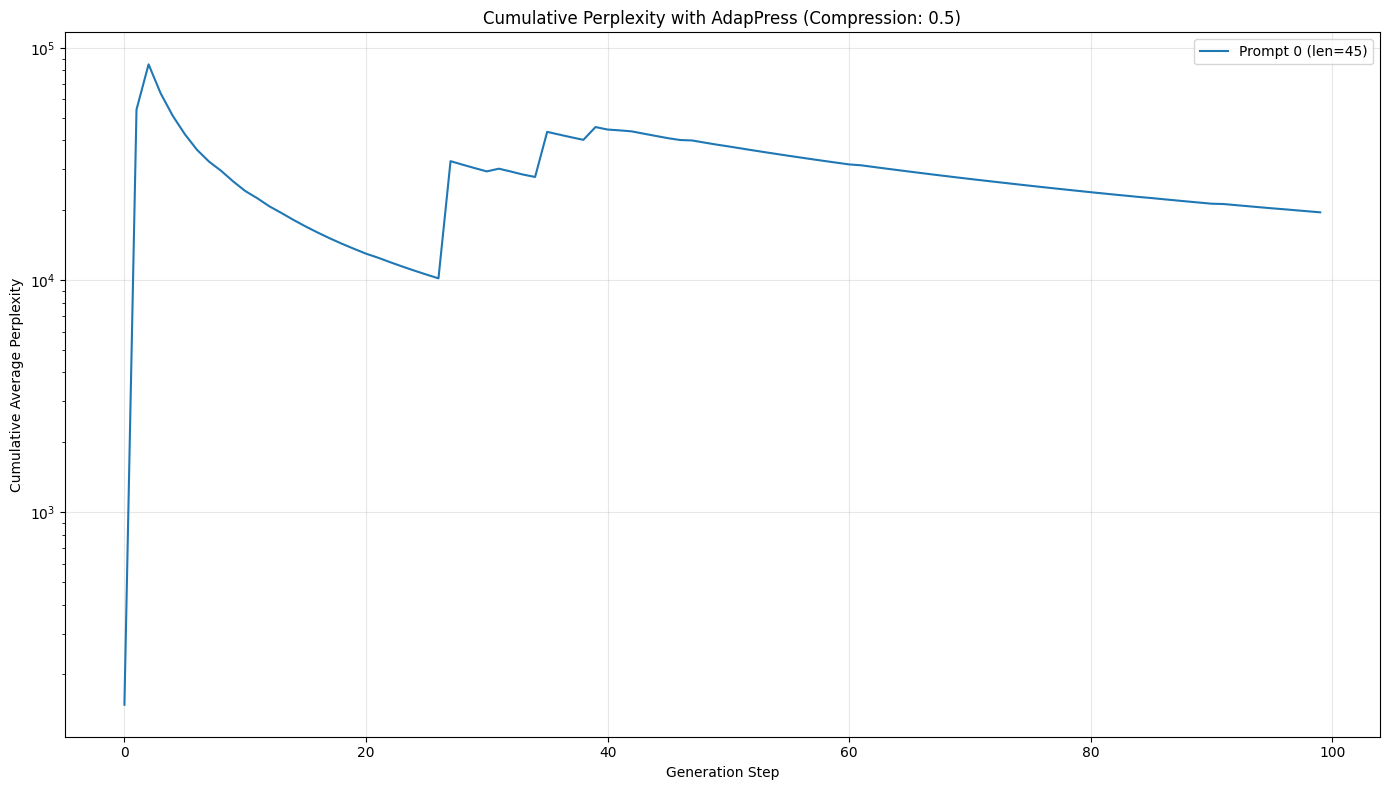

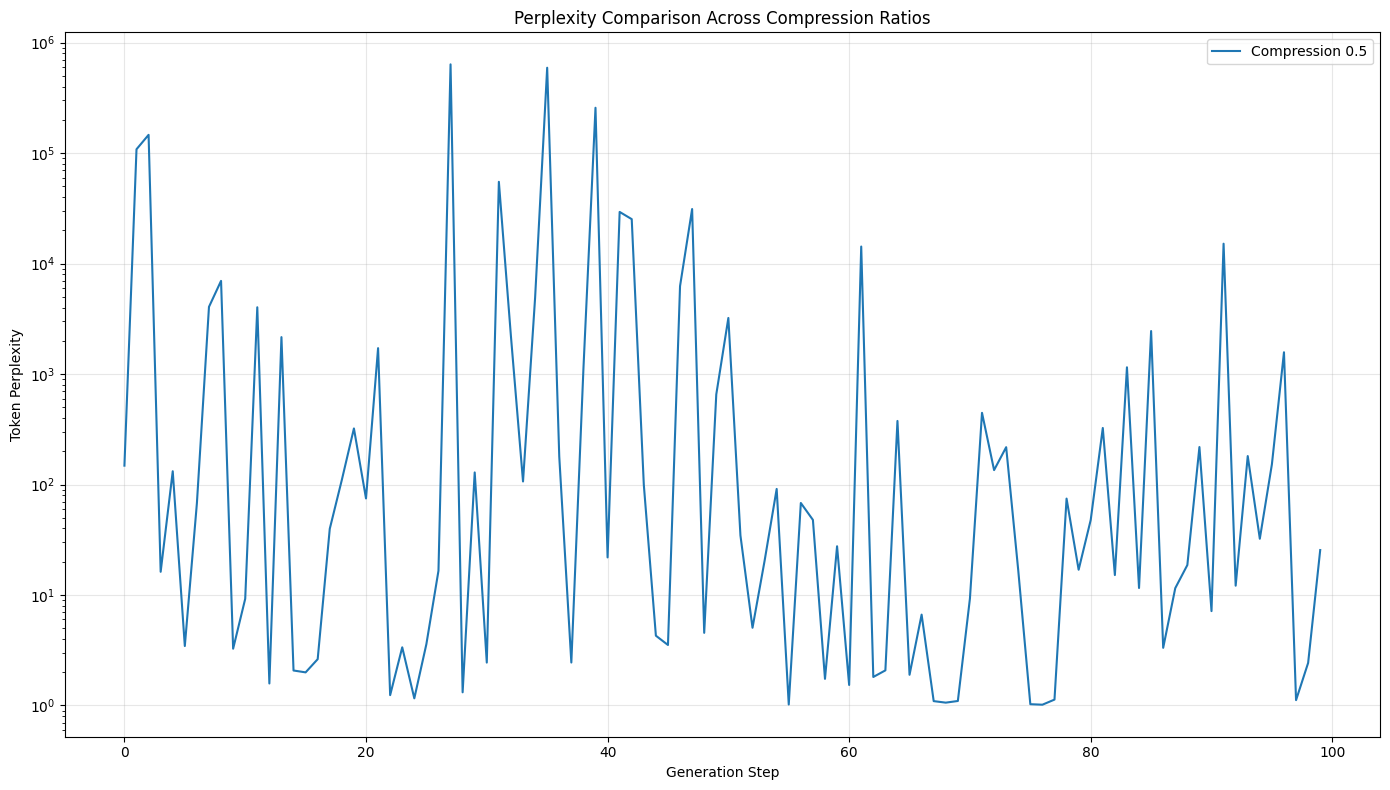

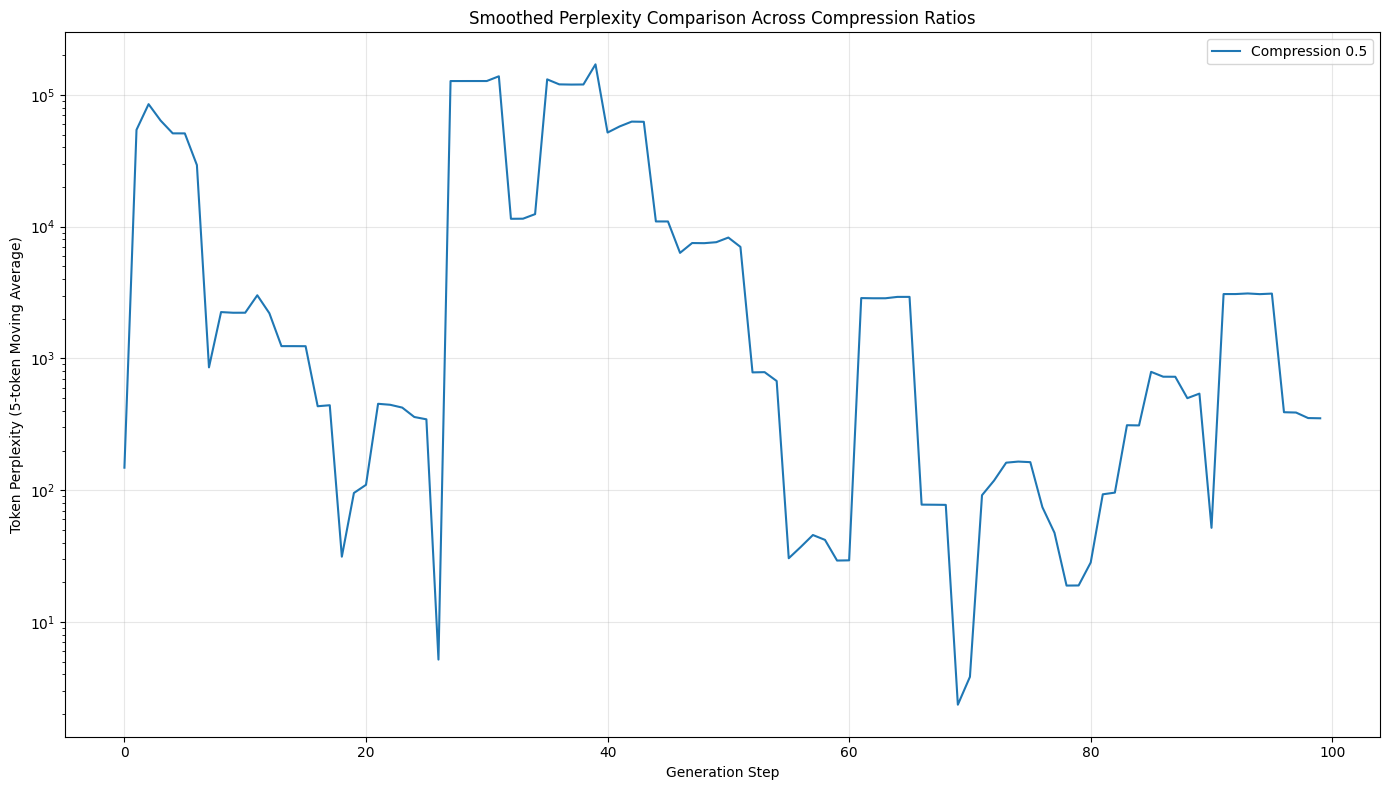

In [13]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_token_by_token_perplexity(model, tokenizer, prompt_text, num_tokens_to_generate=50, device="cuda"):
    """
    Calculate perplexity for each generated token after conditioning on prompt_text.
    
    Returns:
    - generated_text: The full text (prompt + generated)
    - token_perplexities: List of perplexities for each generated token
    - token_texts: The text of each generated token
    """
    model.eval()
    
    # Tokenize prompt
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)
    
    # Store perplexity for each generated token
    token_perplexities = []
    token_texts = []
    generated_text = prompt_text

    press = AdapPress(compression_ratio)

    with press(model):
        # Generate tokens one by one and calculate perplexity
        for _ in range(num_tokens_to_generate):
            with torch.no_grad():
                # Get model outputs
                outputs = model(input_ids)
                logits = outputs.logits
                
                # Get the next token probabilities from the last position
                next_token_logits = logits[0, -1, :]
                
                # Convert logits to probabilities
                next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                
                # Sample the next token (you can use different sampling strategies)
                next_token = torch.multinomial(next_token_probs, num_samples=1)
                
                # Calculate perplexity for this token: perplexity = 1/probability
                token_prob = next_token_probs[next_token].item()
                token_perplexity = 1.0 / token_prob  # or you can use 2^(-log2(prob))
                token_perplexities.append(token_perplexity)
                
                # Convert token to text
                token_text = tokenizer.decode(next_token)
                token_texts.append(token_text)
                generated_text += token_text
                
                # Update input_ids for next iteration
                input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
    
    return generated_text, token_perplexities, token_texts

def evaluate_wikitext_generation_perplexity(model_name, prompt_lengths=[0, 256, 512, 1024], 
                                           tokens_to_generate=100, num_samples=10):
    """
    Evaluate generation perplexity on WikiText-2 dataset with various prompt lengths.
    """
    # Load model and tokenizer
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AutoModelForCausalLM.from_pretrained(model_name, attn_implementation="eager").to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    
    # Load WikiText-2 test dataset (much smaller than PG19)
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    # Filter out empty strings and very short texts
    dataset = dataset.filter(lambda example: len(example['text']) > 100)
    
    # Concatenate some examples to have longer texts for prompting
    concatenated_texts = []
    current_text = ""
    
    for item in dataset:
        if item['text'].strip():  # Skip empty lines
            current_text += item['text'] + " "
            # Once we have a reasonably sized chunk, save it
            if len(current_text) > 10000:  # 10k chars should be enough for most prompt sizes
                concatenated_texts.append(current_text)
                current_text = ""
    
    # Add the last chunk if it's non-empty
    if current_text:
        concatenated_texts.append(current_text)
    
    # Ensure we don't exceed the number of samples
    if num_samples:
        concatenated_texts = concatenated_texts[:min(num_samples, len(concatenated_texts))]
    
    results = []
    
    # Process each text
    for text_idx, text in enumerate(tqdm(concatenated_texts)):
        for prompt_length in prompt_lengths:
            sample_result = {
                "text_id": text_idx,
                "prompt_length": prompt_length
            }
            
            # Get prompt text according to prompt length
            if prompt_length == 0:
                # If prompt length is 0, start with empty string
                prompt_text = ""
            else:
                # Otherwise use the first prompt_length characters
                # Convert to tokens and back to ensure we have exact token counts
                tokens = tokenizer.encode(text, add_special_tokens=False, return_tensors="pt")[0]
                prompt_tokens = tokens[:min(prompt_length, len(tokens))]
                prompt_text = tokenizer.decode(prompt_tokens)
            
            # Calculate token-by-token perplexity during generation
            try:
                generated_text, token_perplexities, token_texts = calculate_token_by_token_perplexity(
                    model, tokenizer, prompt_text, 
                    num_tokens_to_generate=tokens_to_generate, 
                    device=device
                )
                
                # Record results
                sample_result["mean_token_perplexity"] = np.mean(token_perplexities)
                sample_result["median_token_perplexity"] = np.median(token_perplexities)
                sample_result["max_token_perplexity"] = max(token_perplexities)
                sample_result["min_token_perplexity"] = min(token_perplexities)
                sample_result["token_perplexities"] = token_perplexities
                sample_result["generated_tokens"] = token_texts
                
                results.append(sample_result)
                
                print(f"Text {text_idx}, Prompt Length {prompt_length}: Mean PPL = {sample_result['mean_token_perplexity']:.2f}")
            except Exception as e:
                print(f"Error processing text {text_idx} with prompt length {prompt_length}: {e}")
    
    return results

def analyze_perplexity_results(results):
    """
    Analyze and summarize perplexity results.
    """
    # Convert to DataFrame
    df = pd.DataFrame([{k: v for k, v in r.items() if k not in ["token_perplexities", "generated_tokens"]} 
                        for r in results])
    
    # Group by prompt length
    grouped = df.groupby("prompt_length")
    
    # Calculate statistics
    stats = grouped.agg({
        "mean_token_perplexity": ["mean", "std"],
        "median_token_perplexity": "mean",
        "max_token_perplexity": "mean",
        "min_token_perplexity": "mean"
    })
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    prompt_lengths = sorted(df["prompt_length"].unique())
    means = [stats.loc[pl]["mean_token_perplexity"]["mean"] for pl in prompt_lengths]
    stds = [stats.loc[pl]["mean_token_perplexity"]["std"] for pl in prompt_lengths]
    
    plt.errorbar(prompt_lengths, means, yerr=stds, marker='o', linestyle='-', capsize=5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Context Length (tokens)')
    plt.ylabel('Mean Token Perplexity')
    plt.title('Generation Perplexity vs Context Length on WikiText-2')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    # Add non-zero to x-axis if we have zero prompt length
    if 0 in prompt_lengths:
        plt.xticks([0.1] + [x for x in prompt_lengths if x > 0], 
                   ["0"] + [str(x) for x in prompt_lengths if x > 0])
    
    plt.tight_layout()
    plt.savefig("token_generation_perplexity_wikitext.png")
    plt.show()
    
    # Also plot perplexity over generation steps for different prompt lengths
    plt.figure(figsize=(14, 8))
    
    # For each prompt length, get the average perplexity at each generation step
    max_steps = min(100, max([len(r["token_perplexities"]) for r in results]))
    
    for prompt_length in prompt_lengths:
        # Get all results with this prompt length
        prompt_results = [r for r in results if r["prompt_length"] == prompt_length]
        
        # Average perplexity at each step
        step_perplexities = []
        for step in range(max_steps):
            step_ppls = [r["token_perplexities"][step] for r in prompt_results 
                         if step < len(r["token_perplexities"])]
            if step_ppls:
                step_perplexities.append(np.mean(step_ppls))
            else:
                step_perplexities.append(np.nan)
                
        plt.plot(range(len(step_perplexities)), step_perplexities, label=f"Prompt Length {prompt_length}")
    
    plt.xlabel('Generation Step')
    plt.ylabel('Mean Token Perplexity')
    plt.title('Perplexity Across Generation Steps by Prompt Length')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("perplexity_by_generation_step.png")
    plt.show()
    
    return stats

if __name__ == "__main__":
    # Replace with your model name
    model_name = "HuggingFaceTB/SmolLM-135M"
    
    # Define prompt lengths to evaluate (smaller range for WikiText)
    prompt_lengths = [64]
    
    # Run evaluation
    results = evaluate_wikitext_generation_perplexity(
        model_name=model_name,
        prompt_lengths=prompt_lengths,
        tokens_to_generate=100,  # Number of tokens to generate and measure perplexity on
        num_samples=10  # Number of WikiText samples to evaluate
    )
    
    # Analyze results
    stats = analyze_perplexity_results(results)
    print("\nPerplexity Statistics by Prompt Length:")
    print(stats)
    
    # Save detailed results
    import json
    with open("wikitext_perplexity_detailed.json", "w") as f:
        json.dump([{k: v if not isinstance(v, np.ndarray) else v.tolist() 
                   for k, v in r.items()} for r in results], f)

Target text: w @-@ profile and heavy armour protection made them ideal for running gauntlets . Mines and obstruct...
Processing prompt 1/6
  Sentence-level Perplexity: 336.05
Processing prompt 2/6
  Sentence-level Perplexity: 261.68
Processing prompt 3/6
  Sentence-level Perplexity: 343.43
Processing prompt 4/6
  Sentence-level Perplexity: 227.12
Processing prompt 5/6
  Sentence-level Perplexity: 169.73
Processing prompt 6/6
  Sentence-level Perplexity: 119.98

Summary:
Prompt length 3: Sentence-level PPL = 336.05
Prompt length 5: Sentence-level PPL = 261.68
Prompt length 11: Sentence-level PPL = 343.43
Prompt length 27: Sentence-level PPL = 227.12
Prompt length 54: Sentence-level PPL = 169.73
Prompt length 106: Sentence-level PPL = 119.98


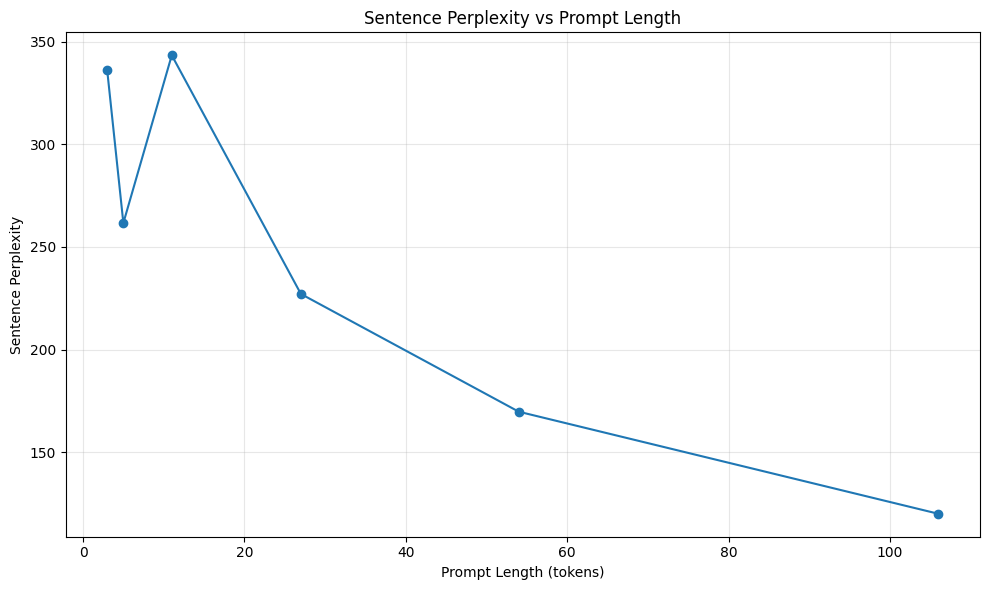

In [16]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_perplexity_for_target(model_name, prompt_texts, target_text, 
                                   compression_ratio=0.5,
                                   device="cuda"):
    """
    Calculate perplexity when generating the same target text after different prompts.
    
    Args:
        model_name: Name of the HuggingFace model to use
        prompt_texts: List of texts to use as prompts (different lengths)
        target_text: The target text to generate and measure perplexity on
        compression_ratio: Compression ratio for AdapPress
        device: Device to run the model on (cuda or cpu)
    """
    # Load model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name, attn_implementation="eager").to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Initialize AdapPress with the specified compression ratio
    press = AdapPress(compression_ratio)
    
    results = []
    
    # Process each prompt
    for prompt_idx, prompt_text in enumerate(prompt_texts):
        print(f"Processing prompt {prompt_idx+1}/{len(prompt_texts)} (length: {len(tokenizer.encode(prompt_text))} tokens)")
        
        # Tokenize prompt
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors="pt").to(device)
        
        # Tokenize target
        target_tokens = tokenizer.encode(target_text, add_special_tokens=False, return_tensors="pt").to(device)
        
        # Record perplexity for each target token
        token_perplexities = []
        token_texts = []
        
        # Activate AdapPress
        with press(model):
            # Initialize with prompt
            current_input = prompt_tokens
            
            # Generate target tokens one by one
            for i in range(len(target_tokens[0])):
                with torch.no_grad():
                    # Get outputs from current input
                    outputs = model(current_input)
                    logits = outputs.logits
                    
                    # Get probabilities for the next token
                    next_token_logits = logits[0, -1, :]
                    next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                    
                    # Get the target token for this position
                    target_token = target_tokens[0, i].item()
                    
                    # Get probability of the target token
                    target_prob = next_token_probs[target_token].item()
                    
                    # Calculate perplexity as 1/probability
                    token_perplexity = 1.0 / target_prob
                    token_perplexities.append(token_perplexity)
                    
                    # Get the token text
                    token_text = tokenizer.decode([target_token])
                    token_texts.append(token_text)
                    
                    # Update input by adding this target token
                    current_input = torch.cat([current_input, target_tokens[:, i:i+1]], dim=1)
        
        # Calculate metrics
        mean_perplexity = np.mean(token_perplexities)
        median_perplexity = np.median(token_perplexities)
        
        # Save results for this prompt
        results.append({
            "prompt_idx": prompt_idx,
            "prompt_length": len(tokenizer.encode(prompt_text)),
            "prompt_text": prompt_text,
            "target_text": target_text,
            "token_perplexities": token_perplexities,
            "token_texts": token_texts,
            "mean_perplexity": mean_perplexity,
            "median_perplexity": median_perplexity
        })
        
        print(f"  Mean Perplexity: {mean_perplexity:.2f}, Median: {median_perplexity:.2f}")
    
    return results

def plot_perplexity_results(results):
    """
    Create visualizations from perplexity results.
    """
    # Sort results by prompt length
    results.sort(key=lambda x: x["prompt_length"])
    
    # Extract prompt lengths and perplexity metrics
    prompt_lengths = [r["prompt_length"] for r in results]
    mean_perplexities = [r["mean_perplexity"] for r in results]
    median_perplexities = [r["median_perplexity"] for r in results]
    
    # Plot 1: Mean and median perplexity vs prompt length
    plt.figure(figsize=(12, 7))
    plt.plot(prompt_lengths, mean_perplexities, 'o-', label='Mean Perplexity')
    plt.plot(prompt_lengths, median_perplexities, 's-', label='Median Perplexity')
    plt.xlabel('Prompt Length (tokens)')
    plt.ylabel('Perplexity')
    plt.title('Perplexity vs Prompt Length')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("perplexity_vs_prompt_length.png")
    
    # Plot 2: Perplexity for each target token by prompt length
    plt.figure(figsize=(15, 8))
    
    # Get max sequence length
    max_seq_len = max([len(r["token_perplexities"]) for r in results])
    
    for i, result in enumerate(results):
        # Pad with NaN if needed
        padded_perplexities = result["token_perplexities"] + [np.nan] * (max_seq_len - len(result["token_perplexities"]))
        plt.plot(
            range(max_seq_len), 
            padded_perplexities,
            label=f'Prompt length: {result["prompt_length"]}'
        )
    
    plt.xlabel('Target Token Position')
    plt.ylabel('Token Perplexity')
    plt.title('Perplexity by Token Position for Different Prompt Lengths')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.savefig("perplexity_by_position.png")
    
    # Plot 3: Heatmap of perplexity across tokens and prompt lengths
    plt.figure(figsize=(15, 10))
    
    # Create a matrix of perplexities
    perplexity_matrix = np.ones((len(results), max_seq_len)) * np.nan
    for i, result in enumerate(results):
        perp_array = np.array(result["token_perplexities"])
        perplexity_matrix[i, :len(perp_array)] = perp_array
    
    # Create a heatmap with log scale
    perplexity_matrix_log = np.log10(perplexity_matrix) 
    
    plt.imshow(perplexity_matrix_log, aspect='auto', cmap='viridis')
    plt.colorbar(label='Log10(Perplexity)')
    plt.xlabel('Target Token Position')
    plt.ylabel('Prompt Length Index')
    
    # Use actual prompt lengths as y-tick labels
    plt.yticks(range(len(prompt_lengths)), [str(l) for l in prompt_lengths])
    
    plt.title('Log Perplexity Heatmap by Token Position and Prompt Length')
    plt.tight_layout()
    plt.savefig("perplexity_heatmap.png")
    
    return

def create_variable_length_prompts(base_text, num_prompts=5, min_length=16, max_length=1024):
    """
    Create prompts of varying lengths from a base text.
    """
    # Ensure we have sufficient text length
    if len(base_text) < max_length:
        print(f"Warning: Base text ({len(base_text)} chars) shorter than max_length ({max_length})")
        max_length = min(len(base_text) - 100, max_length)  # Leave some text for the target
    
    # Create exponentially increasing prompt lengths
    if num_prompts > 1:
        lengths = np.logspace(np.log10(min_length), np.log10(max_length), num_prompts).astype(int)
    else:
        lengths = [min_length]
    
    prompts = []
    for length in lengths:
        prompts.append(base_text[:length])
    
    return prompts

def get_wikitext_sample():
    """
    Get a sample text from WikiText for prompts and target.
    """
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    # Find a long enough article
    for item in dataset:
        if len(item['text']) > 2000 and item['text'].strip():
            text = item['text']
            # Split into prompt base and target
            prompt_base = text[:1500]
            target = text[1500:1700]  # 200 character target
            return prompt_base, target
    
    raise ValueError("Could not find a suitable WikiText article")

if __name__ == "__main__":
    # Use the specified model
    model_name = "HuggingFaceTB/SmolLM-135M"
    compression_ratio = 0.5
    
    # Get sample text
    prompt_base, target_text = get_wikitext_sample()
    print(f"Target text: {target_text[:100]}...")
    
    # Create prompts of different lengths
    prompts = create_variable_length_prompts(
        prompt_base, 
        num_prompts=6,
        min_length=16, 
        max_length=512
    )
    
    # Calculate perplexity for each prompt
    results = calculate_perplexity_for_target(
        model_name=model_name,
        prompt_texts=prompts,
        target_text=target_text,
        compression_ratio=compression_ratio,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    # Plot results
    plot_perplexity_results(results)
    
    # Print summary
    print("\nSummary:")
    for result in sorted(results, key=lambda x: x["prompt_length"]):
        print(f"Prompt length {result['prompt_length']}: Mean PPL = {result['mean_perplexity']:.2f}, "
              f"Median PPL = {result['median_perplexity']:.2f}")